# Vector Mediator Constraints

In [1]:
from itertools import cycle
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm, trange
from collections import defaultdict
from scipy.interpolate import interp1d
from matplotlib.ticker import LogLocator, NullFormatter

from hazma.parameters import (
    sv_inv_MeV_to_cm3_per_s,
    muon_mass as m_mu,
    charged_pion_mass as m_pi,
    neutral_pion_mass as m_pi0,
    electron_mass as m_e,
    omega_h2_cdm
)
from hazma.gamma_ray_parameters import *

from hazma.theory import TheoryDec
from hazma.scalar_mediator import HiggsPortal, HeavyQuark
from hazma.vector_mediator import KineticMixing, QuarksOnly
from hazma.single_channel import SingleChannelAnn, SingleChannelDec
from hazma.relic_density import relic_density

import pickle
from skimage.measure import find_contours

In [2]:
colors = ['#1f77b4', 
          '#ff7f0e',
          '#2ca02c',
          '#d62728',
          '#9467bd',
          '#8c564b',
          '#e377c2',
          '#7f7f7f',
          '#bcbd22',
          '#17becf']

## Tools

In [3]:
def __fix_contours(contours, p1s, p2s):
    """
    Fix the contours produced by skimage's marching squares algorithm. Note
    that their algorithm determines the contours based on the indices
    and not actually coordinates.

    Parameters
    ----------
    contours : array-like
        Contours produced by skimage.
    p1s: array-like
        Array of the horizontal-axis parameters.
    p2s: array-like
        Array of the vertical-axis parameters.

    Returns
    -------
    new_contours: array-like
        New contours with coordinates instead of indices.
    """
    new_contours = []

    for contour in contours:
        _p2s, _p1s = contour.T

        new_p2s = np.interp(_p2s, np.arange(len(p2s)), p2s)
        new_p1s = np.interp(_p1s, np.arange(len(p1s)), p1s)

        new_contours.append([new_p1s, new_p2s])

    return new_contours

In [4]:
# Base figure size
fig_dim = 4
mpl_colors = 2*[c["color"] for c in plt.rcParams["axes.prop_cycle"]]


# Other constants
T_obs_nt = 1e6  # s
v_mw = 1e-3
x_kd = 1e-6  # DM mass divided by T_kd

# This is approximately the same as `gc_bg_model`, but does not constrain
# the input energies.
gc_bg_model_approx = BackgroundModel(
    [0, 1e5], lambda e: 7 * default_bg_model.dPhi_dEdOmega(e)
)
# Best selection of targets
nt_targets_ann = {
    "gc_ein_1_arcmin_cone_optimistic": (
        gc_targets_optimistic["ein"]["1 arcmin cone"], gc_bg_model_approx
    ),
    "gc_nfw_1_arcmin_cone": (gc_targets["nfw"]["1 arcmin cone"], gc_bg_model_approx),
    "m31_nfw_1_arcmin_cone": (m31_targets["nfw"]["1 arcmin cone"], gecco_bg_model),
    "draco_nfw_1_arcmin_cone": (
        draco_targets["nfw"]["1 arcmin cone"], gecco_bg_model
    )
}
nt_targets_dec = {
    "gc_ein_5_deg_optimistic": (
        gc_targets_optimistic["ein"]["5 deg cone"], gc_bg_model_approx
    ),
    "gc_nfw_5_deg": (gc_targets["nfw"]["5 deg cone"], gc_bg_model_approx),
    "m31_nfw_5_deg": (m31_targets["nfw"]["5 deg cone"], gecco_bg_model),
    "draco_nfw_5_deg": (
        draco_targets["nfw"]["5 deg cone"], gecco_bg_model
    )
}


def set_m_med(model, m_med):
    if hasattr(model, "ms"):
        model.ms = m_med
    elif hasattr(model, "mv"):
        model.mv = m_med
    else:
        raise AttributeError("could not determine mediator name")


def get_constraints(
    model,
    mxs,
    m_meds=None,
    nt_targets={},
    existing=["comptel", "egret", "fermi", "integral"],
    cmb=True
):
    constraints = defaultdict(lambda: np.zeros(len(mxs)))

    for i in trange(len(mxs)):
        model.mx = mxs[i]
        if m_meds is not None:
            set_m_med(model, m_meds[i])

        # Constraints from existing data
        for telescope in existing:
            constraints[telescope][i] = model.binned_limit(eval(f"{telescope}_diffuse"))

        # Projections
        for key, (target, bg_model) in nt_targets.items():
            constraints["gecco_" + key][i] = model.unbinned_limit(
                A_eff_gecco,
                energy_res_gecco,
                T_obs_nt,
                target,
                bg_model,
            )

        # TODO: what x_kd value should be used for decaying DM?
        if cmb:
            constraints["cmb"][i] = model.cmb_limit(x_kd=x_kd)

    return dict(constraints)

def get_constraint_label(key):
    label = key.replace("comptel", "COMPTEL")
    label = label.replace("egret", "EGRET ")
    label = label.replace("fermi", "Fermi ")
    label = label.replace("integral", "INTEGRAL ")
    label = label.replace("gecco_", "GECCO ")
    
    label = label.replace("gc_nfw_1_arcmin_cone", "(GC $1'$, NFW)")
    label = label.replace("gc_nfw_5_deg", "(GC $5^\circ$, NFW)")
    label = label.replace("gc_ein_1_arcmin_cone_optimistic", "(GC $1'$, Einasto)")
    label = label.replace("gc_ein_5_deg_optimistic", "(GC $5^\circ$, Einasto)")
    label = label.replace("m31_nfw_1_arcmin_cone", "(M31 $1'$)")
    label = label.replace("m31_nfw_5_deg", "(M31 $5^\circ$)")
    label = label.replace("draco_nfw_1_arcmin_cone", "(Draco $1'$)")
    label = label.replace("draco_nfw_5_deg", "(Draco $5^\circ$)")
    
    return label

def get_fs_label(fs):
    if fs == "e e":
        return r"$e^+ e^-$"
    elif fs == "mu mu":
        return r"$\mu^+ \mu^-$"
    elif fs == "pi pi":
        return r"$\pi^+ \pi^-$"
    elif fs == "pi0 pi0":
        return r"$\pi^0 \pi^0$"
    elif fs == "pi0 g":
        return r"$\pi^0 \gamma$"
    elif fs == "g g":
        return r"$\gamma \gamma$"
    else:
        return fs

def plot_existing(ax, mxs, svs, label, color, y2=1):
    """
    Plots an existing constraint.
    """
    if label == r"CMB ($s$-wave)":
        ax.plot(mxs[fs], svs, "-.k", linewidth=1, label=label)
    elif label == r"CMB ($p$-wave)":
        v_cmbs = 2e-4 * (0.235) * (1 / mxs) * np.sqrt(1e-4 / x_kd)
        ax.plot(
            mxs, svs * (v_mw / v_cmbs)**2, "--k", linewidth=1, label=label
        )
    else:
        ax.fill_between(mxs, svs, y2=y2, label=label, alpha=0.2, color=color)
        ax.loglog(mxs, svs, "-", color=color, linewidth=0.5)

# Global formatting
colors = {
    "comptel": mpl_colors[0],
    "egret": mpl_colors[1],
    "fermi": mpl_colors[2],
    "integral": mpl_colors[3],
    "gc_ein_1_arcmin_cone_optimistic": mpl_colors[4],
    "gc_ein_5_deg_optimistic": mpl_colors[4],
    "gc_nfw_1_arcmin_cone": mpl_colors[5],
    "gc_nfw_5_deg": mpl_colors[5],
    "m31_nfw_1_arcmin_cone": mpl_colors[6],
    "m31_nfw_5_deg": mpl_colors[6],
    "draco_nfw_1_arcmin_cone": mpl_colors[7],
    "draco_nfw_5_deg": mpl_colors[7],
}

linestyles = {
    "gc_ein_1_arcmin_cone_optimistic": "-",
    "gc_ein_5_deg_optimistic": "-",
    "gc_nfw_1_arcmin_cone": "--",
    "gc_nfw_5_deg": "--",
    "m31_nfw_1_arcmin_cone": ":",
    "m31_nfw_5_deg": ":",
    "draco_nfw_1_arcmin_cone": ":",
    "draco_nfw_5_deg": ":",
}

In [5]:
def get_svs_pheno(model, mx, mv, eps, vx=1e-3):
    """
    Converts pheno constraint on stheta to <sigma v>.
    """
    model.eps = eps # pheno constraint
    model.mx = mx
    model.mv = mv
    # Approximate the thermal average as sigma * v
    sv = model.annihilation_cross_sections(
        2 * model.mx * (1 + 0.5 * vx**2)
    )["total"] * vx
    return sv * sv_inv_MeV_to_cm3_per_s


## $M_{V} = 1$ GeV

In [5]:
km = KineticMixing(**{"mx": 1., "mv": 1000.0, "gvxx": 1., "eps": 0.1})
mxs = np.geomspace(0.1, 250.0, 100)

In [5]:
sv_constraints_vms = get_constraints(km, mxs, nt_targets=nt_targets_ann)

/Users/loganmorrison/.pyenv/versions/3.8.6/lib/python3.8/site-packages/hazma/vector_mediator/_vector_mediator_spectra.py:112: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return dnde_decay_v(e_gams, e_v, mv, pw_array, fs)
/Users/loganmorrison/.pyenv/versions/3.8.6/lib/python3.8/site-packages/hazma/vector_mediator/_vector_mediator_spectra.py:112: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return dnde_decay_v(e_gams, e_v, mv, pw_array, fs)
/Users/loganmorrison/.pyenv/versions/3.8.6/lib/python3.8/site-packages/hazma/theory/_theory_gamma_ray_limits.py:236: RuntimeWarning: divide by zero encountered in double_scalars
  bound = prefactor * n_sigma / np.nanmax(snrs[:, 2])
/Users/loganmorrison/.pyenv/versions/3.8.6/lib/python3.8/site-packa

In [21]:
sv_constraints_vms['telescopes'] = np.array([
    np.min([
        sv_constraints_vms['comptel'][i],
        sv_constraints_vms['egret'][i],
        sv_constraints_vms['fermi'][i],
        sv_constraints_vms['integral'][i]
    ])
    for i in range(len(mxs))
])

In [6]:
# BaBar constraint at MV = 1GeV ~ eps < 3.15e-3
pheno = np.array([get_svs_pheno(km, mx, 1000.0, 9.2e-4) for mx in mxs])

In [8]:
# Relic densities
epss = np.logspace(-10, 1, 100)
rds = np.zeros((len(mxs), len(epss)))
for i in trange(len(mxs)):
    km.mx = mxs[i]
    for j, eps in enumerate(epss):
        km.eps = eps
        rds[i,j] = relic_density(km, semi_analytic=False, xf=500)

/Users/loganmorrison/.pyenv/versions/3.8.6/lib/python3.8/site-packages/hazma/relic_density/__init__.py:413: RuntimeWarning: overflow encountered in exp
  return np.array([pf * sv * (np.exp(w[0]) - np.exp(2.0 * _weq - w[0]))])


In [ ]:
rd_mxs, rd_epss = __fix_contours(find_contours(rds.T, omega_h2_cdm), mxs, epss)[0]
rd_svs = [get_svs_pheno(km, rd_mxs[i], 1e3, rd_epss[i]) for i in range(len(rd_mxs))]

In [10]:
km.mx = rd_mxs[-1]
km.eps = rd_epss[-1]
relic_density(km)

0.04586770150910278

In [7]:
""" Save the data
with open('data/kinetic_mixing.p', 'wb') as f:
    pickle.dump(sv_constraints_vms, f)
"""

#Load the data
sv_constraints_vms = None
with open('data/kinetic_mixing.p', 'rb') as f:
    sv_constraints_vms = pickle.load(f)

In [8]:
colors = ['#1f77b4', 
          '#ff7f0e',
          '#2ca02c',
          '#d62728',
          '#9467bd',
          '#8c564b',
          '#e377c2',
          '#7f7f7f',
          '#bcbd22',
          '#17becf']

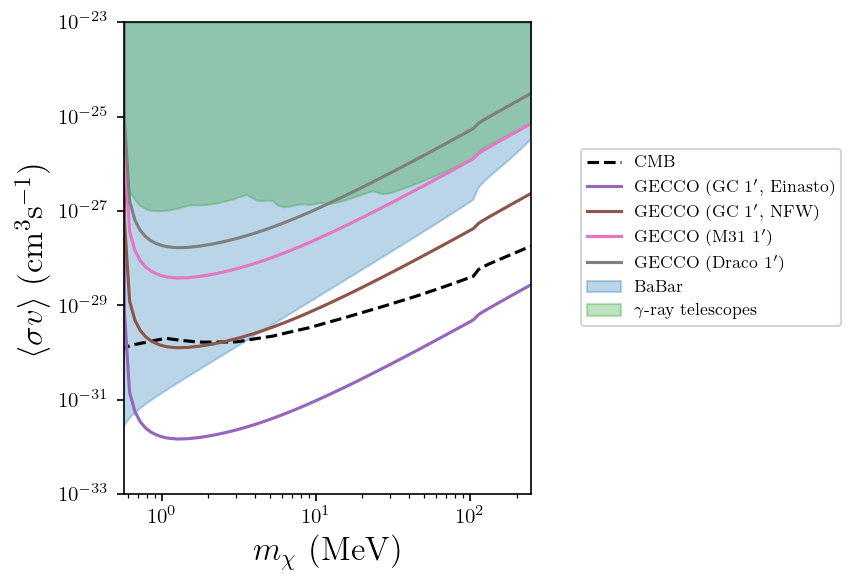

In [10]:
#fig, (ax1, ax2) = plt.subplots(1, 2)
#fig.dpi = 150

plt.figure(dpi=150)

ymin, ymax = [1e-33, 1e-23]

plt.plot(
    mxs, 
    sv_constraints_vms['cmb'], 
    label=r'CMB',
    linestyle="--",
    color="black",
)

#plt.plot(
#    rd_mxs, 
#    rd_svs, 
#    label=r'Thermal Relic',
#    linestyle="-",
#    color="black",
#)


plt.fill_between(
    mxs, 
    pheno, 
    ymax, 
    label=r'BaBar',
    linestyle="-",
    color=colors[0],
    alpha=0.3
)


plt.fill_between(
    mxs, 
    sv_constraints_vms['telescopes'], 
    ymax, 
    label=r'$\gamma$-ray telescopes',
    linestyle="-",
    color=colors[2],
    alpha=0.3
)



plt.plot(
    mxs,     
    sv_constraints_vms['gecco_gc_ein_1_arcmin_cone_optimistic'],  
    label=get_constraint_label('gecco_gc_ein_1_arcmin_cone_optimistic'),
    linestyle="-",
    color=colors[4],
)


plt.plot(
    mxs,     
    sv_constraints_vms['gecco_gc_nfw_1_arcmin_cone'],  
    label=get_constraint_label('gecco_gc_nfw_1_arcmin_cone'),
    linestyle="-",
    color=colors[5],
)


plt.plot(
    mxs,     
    sv_constraints_vms['gecco_m31_nfw_1_arcmin_cone'],  
    label=get_constraint_label('gecco_m31_nfw_1_arcmin_cone'),
    linestyle="-",
    color=colors[6],
)

plt.plot(
    mxs,     
    sv_constraints_vms['gecco_draco_nfw_1_arcmin_cone'],  
    label=get_constraint_label('gecco_draco_nfw_1_arcmin_cone'),
    linestyle="-",
    color=colors[7],
)
    

plt.yscale('log')
plt.xscale('log')
    
plt.ylim([ymin, ymax])
plt.xlim([m_e*1.1, np.max(mxs)])
plt.ylabel(r'$\langle\sigma v\rangle \ (\mathrm{cm}^3\mathrm{s}^{-1})$',fontsize=16)
plt.xlabel(r'$m_{\chi} \ (\mathrm{MeV})$',fontsize=16)

plt.legend(loc=0, bbox_to_anchor=(1.1,0.75), fontsize=8)
plt.tight_layout()
#plt.show()
plt.savefig('figures/gecco_kinetic_mixing.pdf')

## mx = mv/3

In [6]:
alphad = 0.5
gvxx = np.sqrt(4.0 * np.pi * alphad)

mxs = np.geomspace(0.1, 250.0, 100)
mvs = 3 * mxs
km = KineticMixing(**{"mx": 1., "mv": 1000.0, "gvxx": 1., "eps": 0.1})

### Tools for computing PHENO constraints

In [62]:
babar_data.T[1][0]

5.554682069677126e-09

In [56]:
babar_data = np.genfromtxt("data/BaBar.dat",delimiter=",")
lsnd_data = np.genfromtxt("data/LSND.dat",delimiter=",")
e137_data = np.genfromtxt("data/E137.dat", delimiter=",")

babar_interp = interp1d(babar_data.T[0], babar_data.T[1])
lsnd_interp = interp1d(lsnd_data.T[0], lsnd_data.T[1])
e137_interp = interp1d(e137_data.T[0], e137_data.T[1])

def babar_constraint(mx, mv=None, alphad=0.5, vx=1e-3):
    if mx * 1e-3  > babar_data.T[0][-1]:
        return np.inf
    if mx * 1e-3 < babar_data.T[0][0]:
        y = babar_data.T[1][0]
    else:
        y = babar_interp(mx * 1e-3)
    mv = 3.0 * mx if mv is None else mv
    gvxx = np.sqrt(4.0 * np.pi * alphad)
    # y = eps**2 * alphad / 3**4
    eps = np.sqrt((mx / mv)**4 * y / alphad)
    model = KineticMixing(**{"mx": mx, "mv": 3.0 * mx, "gvxx": gvxx, "eps": eps})
    sv = model.annihilation_cross_sections(2 * model.mx * (1 + 0.5 * vx**2))["total"] * vx
    return sv * sv_inv_MeV_to_cm3_per_s
    
def lsnd_constraint(mx, mv=None, alphad=0.5, vx=1e-3):
    if mx * 1e-3 > lsnd_data.T[0][-1]:
        return np.inf
    if mx * 1e-3 < lsnd_data.T[0][0]:
        y = lsnd_data.T[1][0]
    else:
        y = lsnd_interp(mx * 1e-3)
    mv = 3.0 * mx if mv is None else mv
    gvxx = np.sqrt(4.0 * np.pi * alphad)
    # y = eps**2 * alphad / 3**4
    eps = np.sqrt((mx / mv)**4 * y / alphad)
    model = KineticMixing(**{"mx": mx, "mv": 3.0 * mx, "gvxx": gvxx, "eps": eps})
    sv = model.annihilation_cross_sections(2 * model.mx * (1 + 0.5 * vx**2))["total"] * vx
    return sv * sv_inv_MeV_to_cm3_per_s

def e137_constraint(mx, mv=None, alphad=0.5, vx=1e-3):
    """
    Compute the constraint on kinetix mixing model from E137 (see arXiv:1808.0077).
    The mediator mass is assumed to be 
    """
    # mx * 1e-3 < e137_data.T[0][0] or 
    if mx * 1e-3 > e137_data.T[0][-1]:
        return np.inf
    if mx * 1e-3 < e137_data.T[0][0]:
        y = e137_data.T[1][0]
    else:
        y = e137_interp(mx * 1e-3)
    mv = 3.0 * mx if mv is None else mv
    gvxx = np.sqrt(4.0 * np.pi * alphad)
    # y = eps**2 * alphad / 3**4
    eps = np.sqrt((mx / mv)**4 * y / alphad)
    model = KineticMixing(**{"mx": mx, "mv": mv, "gvxx": gvxx, "eps": eps})
    sv = model.annihilation_cross_sections(2 * model.mx * (1 + 0.5 * vx**2))["total"] * vx
    return sv * sv_inv_MeV_to_cm3_per_s

### Compute the $\gamma$-ray constraints

In [8]:
sv_constraints_vms2 = get_constraints(km, mxs, nt_targets=nt_targets_ann, m_meds=mvs)

/Users/loganmorrison/.pyenv/versions/3.8.6/lib/python3.8/site-packages/hazma/theory/_theory_gamma_ray_limits.py:236: RuntimeWarning: divide by zero encountered in double_scalars
  bound = prefactor * n_sigma / np.nanmax(snrs[:, 2])
/Users/loganmorrison/.pyenv/versions/3.8.6/lib/python3.8/site-packages/hazma/background_model.py:48: UserWarning: The gamma ray background model is not applicable for energy 0.100000 MeV.
  warnings.warn(
/Users/loganmorrison/.pyenv/versions/3.8.6/lib/python3.8/site-packages/hazma/theory/_theory_cmb.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  return p_ann * self.mx / self.f_eff(x_kd)
/Users/loganmorrison/.pyenv/versions/3.8.6/lib/python3.8/site-packages/hazma/vector_mediator/_vector_mediator_spectra.py:112: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return dnde_decay_v(e_gams, e_v, mv, pw_array, fs)
/Users/loganmorrison/.pyenv/versions/3.8.6/lib/python3.8/site-packages/hazma/decay.py:54: Integrat

In [22]:
sv_constraints_vms2['telescopes'] = np.array([
    np.min([
        sv_constraints_vms2['comptel'][i],
        sv_constraints_vms2['egret'][i],
        sv_constraints_vms2['fermi'][i],
        sv_constraints_vms2['integral'][i]
    ])
    for i in range(len(mxs))
])

### Compute the relic densities

In [13]:
mxs = np.geomspace(0.1, 250.0, 100)
mvs = 3 * mxs
km = KineticMixing(**{"mx": 1., "mv": 1000.0, "gvxx": 1., "eps": 0.1})

# Relic densities
epss = np.logspace(-10, 1, 100)
rds = np.zeros((len(mxs), len(epss)))
for i in trange(len(mxs)):
    km.mx = mxs[i]
    km.mv = mvs[i]
    for j, eps in enumerate(epss):
        km.eps = eps
        rds[i,j] = relic_density(km, semi_analytic=True)

/Users/loganmorrison/.pyenv/versions/3.8.6/lib/python3.8/site-packages/hazma/vector_mediator/_vector_mediator_cross_sections.py:375: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return tcs(


In [28]:
# Relic densities
epss = np.logspace(-10, 1, 20)
rds2 = np.zeros((len(mxs), len(epss)))
for i in trange(len(mxs)):
    km.mx = mxs[i]
    km.mv = mvs[i]
    for j, eps in enumerate(epss):
        km.eps = eps
        rds2[i,j] = relic_density(km, semi_analytic=False, xf=500)

/Users/loganmorrison/.pyenv/versions/3.8.6/lib/python3.8/site-packages/hazma/relic_density/__init__.py:413: RuntimeWarning: overflow encountered in exp
  return np.array([pf * sv * (np.exp(w[0]) - np.exp(2.0 * _weq - w[0]))])


In [14]:
rd_mxs, rd_epss = __fix_contours(find_contours(rds.T, omega_h2_cdm), mxs, epss)[0]
rd_svs = [get_svs_pheno(km, rd_mxs[i], 1e3, rd_epss[i]) for i in range(len(rd_mxs))]

In [30]:
rd2_mxs, rd2_epss = __fix_contours(find_contours(rds2.T, omega_h2_cdm), mxs, epss)[0]
rd2_svs = [get_svs_pheno(km, rd2_mxs[i], 1e3, rd2_epss[i]) for i in range(len(rd2_mxs))]

### Compute PHENO constraints

In [57]:
babar = np.array([babar_constraint(mx) for mx in mxs])
lsnd = np.array([lsnd_constraint(mx) for mx in mxs])
e137 = np.array([e137_constraint(mx) for mx in mxs])
pheno = np.array([np.min([a,b,c]) for a,b,c in zip(babar,lsnd,e137)])

In [58]:
pheno[0]

0.0

In [63]:
babar

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 6.81709955e-24, 1.03740097e-23, 1.07652868e-23,
       1.01776211e-23, 9.23585608e-24, 8.19889374e-24, 7.18379446e-24,
       6.24260746e-24, 5.39540107e-24, 4.64616500e-24, 3.99094782e-24,
       3.42215242e-24, 2.94421846e-24, 2.53342506e-24, 2.17952393e-24,
       1.87508096e-24, 1.60356665e-24, 1.36994137e-24, 1.17016010e-24,
       9.97196666e-25, 8.47067956e-25, 7.19157497e-25, 6.10219593e-25,
       5.19092540e-25, 4.43228075e-25, 3.78444489e-25, 3.23125787e-25,
       2.75890698e-25, 2.35558939e-25, 2.01122198e-25, 1.71719211e-25,
       1.46614404e-25, 1.25179606e-25, 1.06878395e-25, 9.12527236e-26,
      

In [51]:
pheno

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 3.47231378e-28, 5.28403856e-28, 5.48333696e-28,
       5.18400733e-28, 4.70431599e-28, 4.17613555e-28, 3.65909114e-28,
       3.17969420e-28, 2.74816664e-28, 2.41748697e-28, 2.16048165e-28,
       1.93245525e-28, 1.77062171e-28, 1.63984234e-28, 1.53850805e-28,
       1.47877846e-28, 1.46224940e-28, 1.42826827e-28, 1.35710221e-28,
       1.28875939e-28, 1.23853289e-28, 1.18511284e-28, 1.14563747e-28,
       1.10319953e-28, 1.09157006e-28, 1.07796709e-28, 1.05935014e-28,
       1.03556060e-28, 1.02130132e-28, 1.00511924e-28, 9.85172295e-29,
       9.70296101e-29, 9.66023078e-29, 9.55915547e-29, 9.43639627e-29,
      

### Save/Load data

In [9]:
# Save the data
with open('data/kinetic_mixing_mx_third_mv.p', 'wb') as f:
    pickle.dump(sv_constraints_vms2, f)

#Load the data
"""
sv_constraints_vms = None
with open('data/kinetic_mixing_mx_third_mv.p', 'rb') as f:
    sv_constraints_vms = pickle.load(f)
"""

"\nsv_constraints_vms = None\nwith open('data/kinetic_mixing_mx_third_mv.p', 'rb') as f:\n    sv_constraints_vms = pickle.load(f)\n"

### Plots

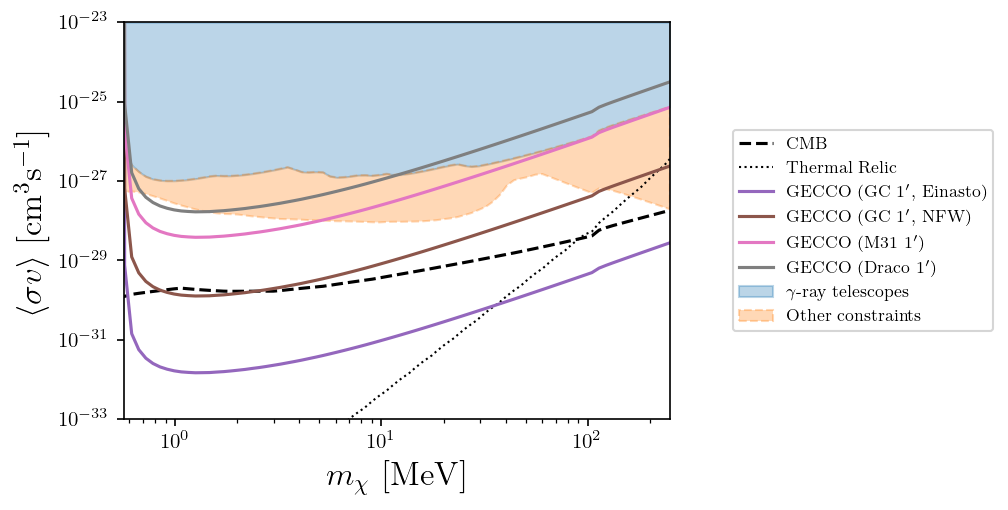

In [73]:
#fig, (ax1, ax2) = plt.subplots(1, 2)
#fig.dpi = 150

plt.figure(dpi=150, figsize=(7, 3.5))

ymin, ymax = [1e-33, 1e-23]

plt.plot(
    mxs, 
    sv_constraints_vms2['cmb'], 
    label=r'CMB',
    linestyle="--",
    color="black",
)

plt.plot(
    rd_mxs, 
    rd_svs, 
    label=r'Thermal Relic',
    linestyle=":",
    color="black",
    linewidth=1,
)


"""

plt.fill_between(
    mxs, 
    lsnd, 
    ymax, 
    label=r'LSND',
    linestyle="-",
    color=colors[1],
    alpha=0.3
)

plt.fill_between(
    mxs, 
    e137, 
    ymax, 
    label=r'E137',
    linestyle="-",
    color=colors[0],
    alpha=0.3
)

plt.fill_between(
    mxs, 
    babar, 
    ymax, 
    label=r'BaBar',
    linestyle="-",
    color=colors[0],
    alpha=0.3
)
"""

plt.fill_between(
    mxs, 
    sv_constraints_vms2['telescopes'], 
    ymax, 
    label=r'$\gamma$-ray telescopes',
    linestyle="-",
    color=colors[0],
    alpha=0.3
)

plt.fill_between(
    mxs, 
    pheno, 
    sv_constraints_vms2['telescopes'], 
    label=r'Other constraints',
    linestyle="--",
    color=colors[1],
    alpha=0.3
)



plt.plot(
    mxs,     
    sv_constraints_vms2['gecco_gc_ein_1_arcmin_cone_optimistic'],  
    label=get_constraint_label('gecco_gc_ein_1_arcmin_cone_optimistic'),
    linestyle="-",
    color=colors[4],
)


plt.plot(
    mxs,     
    sv_constraints_vms2['gecco_gc_nfw_1_arcmin_cone'],  
    label=get_constraint_label('gecco_gc_nfw_1_arcmin_cone'),
    linestyle="-",
    color=colors[5],
)


plt.plot(
    mxs,     
    sv_constraints_vms2['gecco_m31_nfw_1_arcmin_cone'],  
    label=get_constraint_label('gecco_m31_nfw_1_arcmin_cone'),
    linestyle="-",
    color=colors[6],
)

plt.plot(
    mxs,     
    sv_constraints_vms2['gecco_draco_nfw_1_arcmin_cone'],  
    label=get_constraint_label('gecco_draco_nfw_1_arcmin_cone'),
    linestyle="-",
    color=colors[7],
)
    

plt.yscale('log')
plt.xscale('log')
    
plt.ylim([ymin, ymax])
plt.xlim([m_e*1.1, np.max(mxs)])
plt.ylabel(r'$\langle\sigma v\rangle \ [\mathrm{cm}^3\mathrm{s}^{-1}]$',fontsize=16)
plt.xlabel(r'$m_{\chi} \ [\mathrm{MeV}]$',fontsize=16)

plt.legend(loc=0, bbox_to_anchor=(1.1,0.75), fontsize=8)
plt.tight_layout()
#plt.show()
plt.savefig('figures/gecco_kinetic_mixing.pdf')

In [59]:
mxs = np.geomspace(0.1, 250.0, 20)
mvs = 3 * mxs
km = KineticMixing(**{"mx": 1., "mv": 1000.0, "gvxx": 1., "eps": 0.1})

# Relic densities
epss = np.logspace(-10, 1, 20)
rds = np.zeros((len(mxs), len(epss)))
for i in trange(len(mxs)):
    km.mx = mxs[i]
    km.mv = mvs[i]
    for j, eps in enumerate(epss):
        km.eps = eps
        rds[i,j] = relic_density(km, semi_analytic=True)
        
rd_mxs, rd_epss = __fix_contours(find_contours(rds.T, omega_h2_cdm), mxs, epss)[0]
rd_svs = [get_svs_pheno(km, rd_mxs[i],3*rd_mxs[i] , rd_epss[i]) for i in range(len(rd_mxs))]

/Users/loganmorrison/Nextcloud/Research/Hazma/hazma/vector_mediator/_vector_mediator_cross_sections.py:375: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return tcs(


In [60]:
mxs = np.geomspace(0.1, 250.0, 20)
mvs = 3 * mxs
km = KineticMixing(**{"mx": 1., "mv": 1000.0, "gvxx": 0.1, "eps": 0.1})

# Relic densities
epss = np.logspace(-10, 1, 20)
rds2 = np.zeros((len(mxs), len(epss)))
for i in trange(len(mxs)):
    km.mx = mxs[i]
    km.mv = mvs[i]
    for j, eps in enumerate(epss):
        km.eps = eps
        rds2[i,j] = relic_density(km, semi_analytic=True)
        
rd_mxs2, rd_epss2 = __fix_contours(find_contours(rds2.T, omega_h2_cdm), mxs, epss)[0]
rd_svs2 = [get_svs_pheno(km, rd_mxs2[i],3*rd_mxs2[i] , rd_epss2[i]) for i in range(len(rd_mxs2))]

/Users/loganmorrison/Nextcloud/Research/Hazma/hazma/vector_mediator/_vector_mediator_cross_sections.py:375: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return tcs(
/Users/loganmorrison/Nextcloud/Research/Hazma/hazma/vector_mediator/_vector_mediator_cross_sections.py:375: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  pro

/Users/loganmorrison/Nextcloud/Research/Hazma/hazma/vector_mediator/_vector_mediator_cross_sections.py:375: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return tcs(
/Users/loganmorrison/Nextcloud/Research/Hazma/hazma/vector_mediator/_vector_mediator_cross_sections.py:375: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  pro

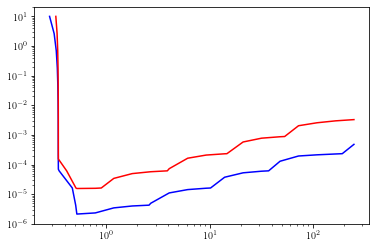

In [61]:
plt.loglog(rd_mxs, rd_epss, c="blue")
plt.loglog(rd_mxs2, rd_epss2, c="red")

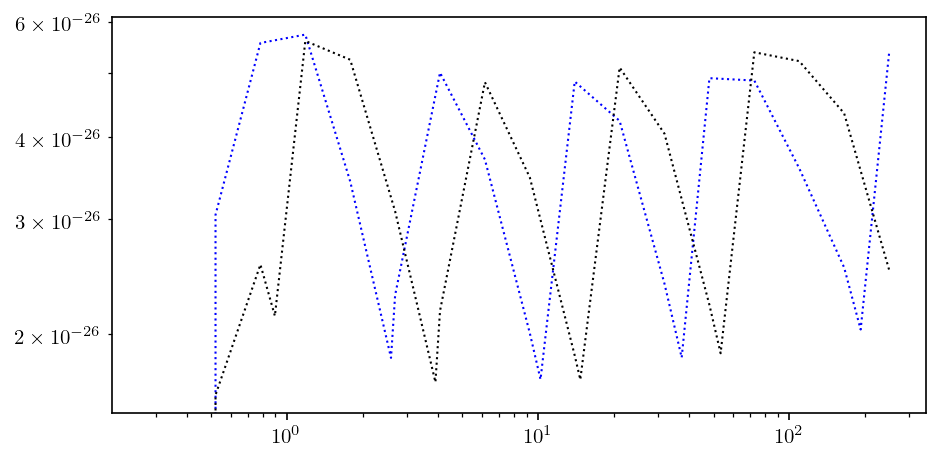

In [62]:
plt.figure(dpi=150, figsize=(7, 3.5))

plt.loglog(
    rd_mxs, 
    rd_svs, 
    label=r'Thermal Relic',
    linestyle=":",
    color="blue",
    linewidth=1,
)

plt.loglog(
    rd_mxs2, 
    rd_svs2, 
    label=r'Thermal Relic',
    linestyle=":",
    color="black",
    linewidth=1,
)